# Spatial Interpolation

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 9)


In [2]:
import rasterio

In [3]:
from rasterio.mask import mask
import geopandas as gpd
import fiona
import pandas as pd

In [4]:
precip = gpd.read_file("precip_sd.geojson")


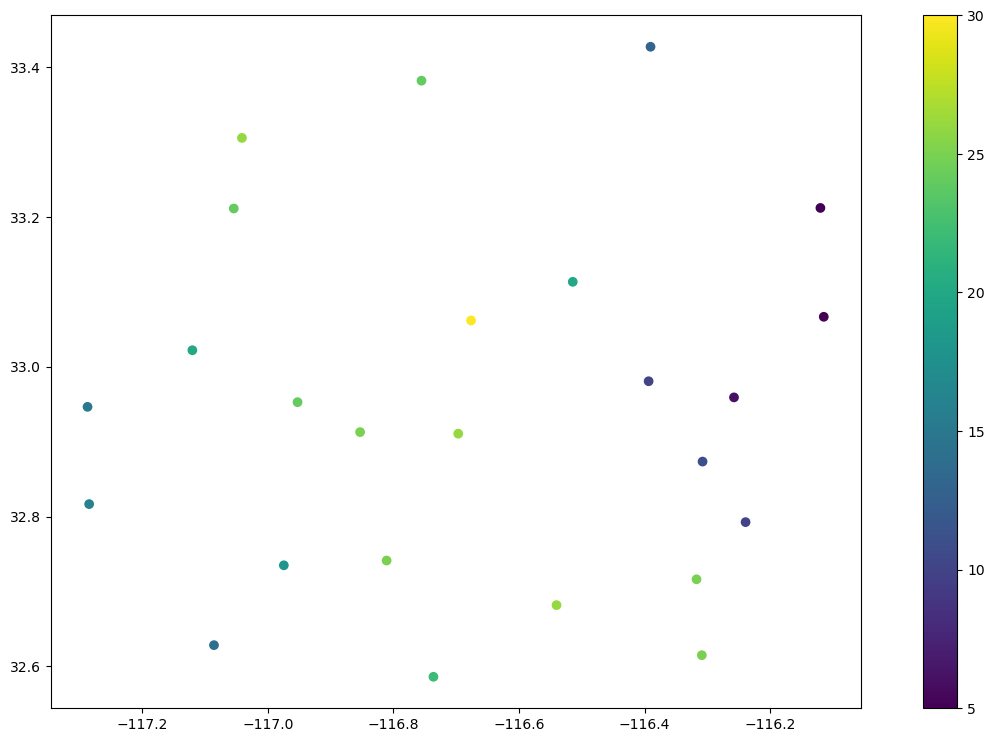

In [5]:
precip.plot(column='inches', legend=True);

In [6]:
county = gpd.read_file("sdcounty.geojson")

In [7]:
m = county.explore()
precip.explore(column='inches', m=m)


## Interpolation Methods

### Voronoi Partition Interpolation

In [8]:
from libpysal.cg import voronoi_frames
points = [(10.2, 5.1), (4.7, 2.2), (5.3, 5.7), (2.7, 5.3)]
regions_df, points_df = voronoi_frames(points)
regions_df.shape
(4, 1)

(4, 1)

<Axes: >

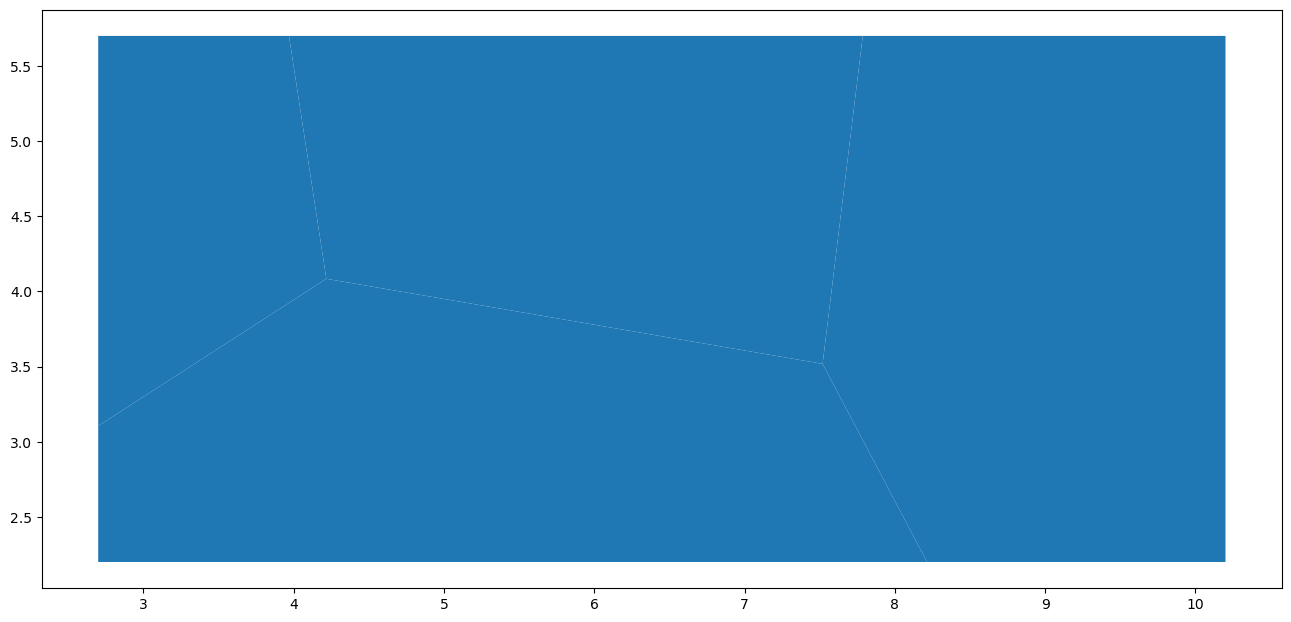

In [9]:
regions_df.plot()

In [10]:
#libpysal.cg.voronoi_frames(points, radius=None, clip='extent')
points = precip.get_coordinates().values

In [11]:
points

array([[-116.11485557,   33.06671401],
       [-116.9527008 ,   32.95272273],
       [-117.28707993,   32.94648004],
       [-116.81087912,   32.74126523],
       [-116.67642472,   33.06180036],
       [-116.75536004,   33.38198687],
       [-116.853125  ,   32.91276871],
       [-117.2845249 ,   32.8166362 ],
       [-116.30785686,   32.87339294],
       [-117.05423452,   33.2113287 ],
       [-117.08576883,   32.62829508],
       [-116.97452738,   32.73489854],
       [-117.04123146,   33.30555124],
       [-116.7363531 ,   32.5860575 ],
       [-116.6968592 ,   32.91063226],
       [-116.30902366,   32.61490005],
       [-117.12014811,   33.02207574],
       [-116.23936964,   32.79254988],
       [-116.25780398,   32.95910185],
       [-116.54036451,   32.68174022],
       [-116.39372071,   32.9806681 ],
       [-116.3174487 ,   32.71622031],
       [-116.12021022,   33.21206119],
       [-116.39070088,   33.42723824],
       [-116.51450478,   33.11339592]])

<Axes: >

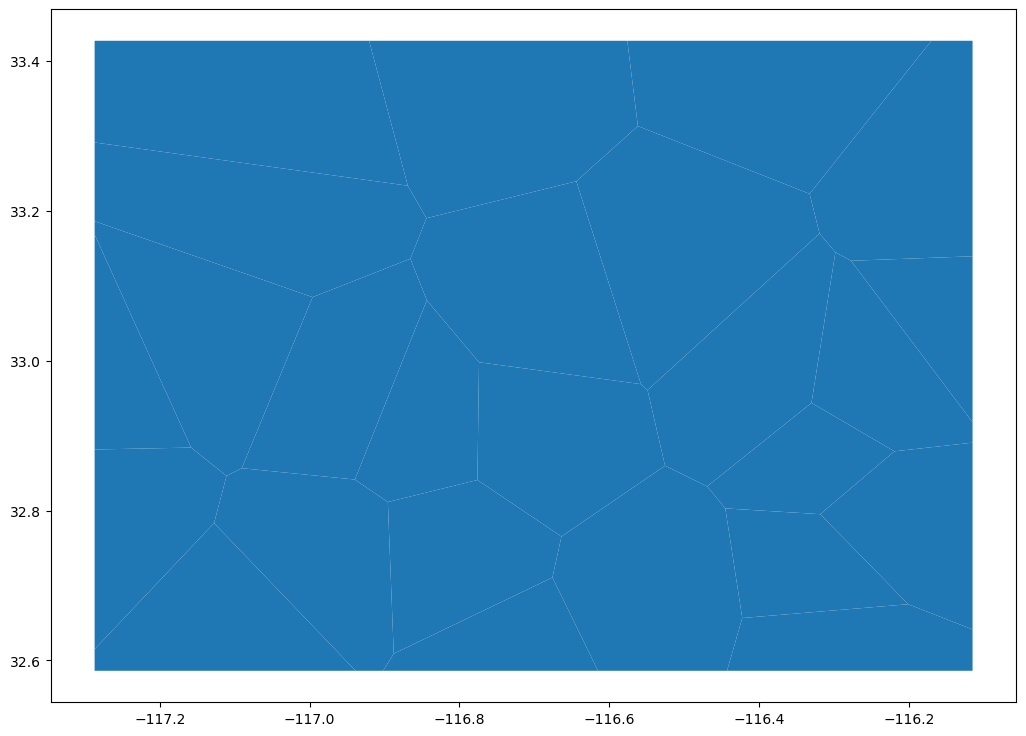

In [12]:
v_gdf, v_p = voronoi_frames(points)

v_gdf.plot()

<Axes: >

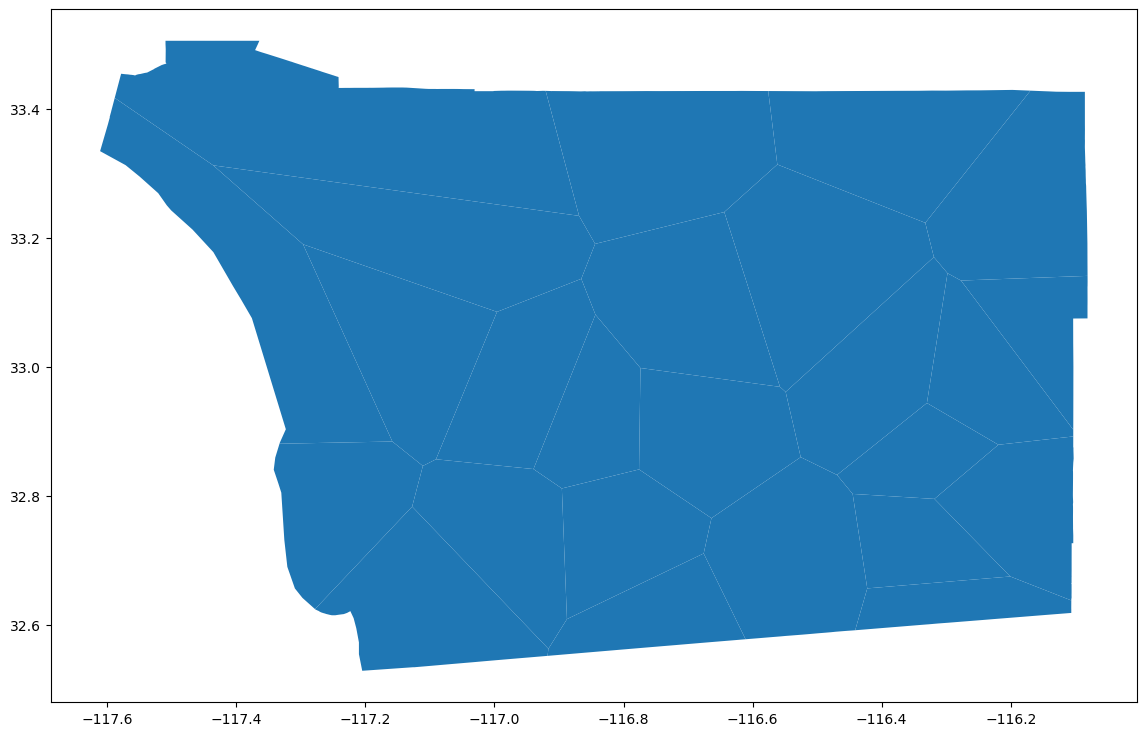

In [13]:
v_gdf, v_p = voronoi_frames(points, clip=county.geometry[0])

v_gdf.plot()

In [14]:
v_gdf['inches'] = precip.inches

<Axes: >

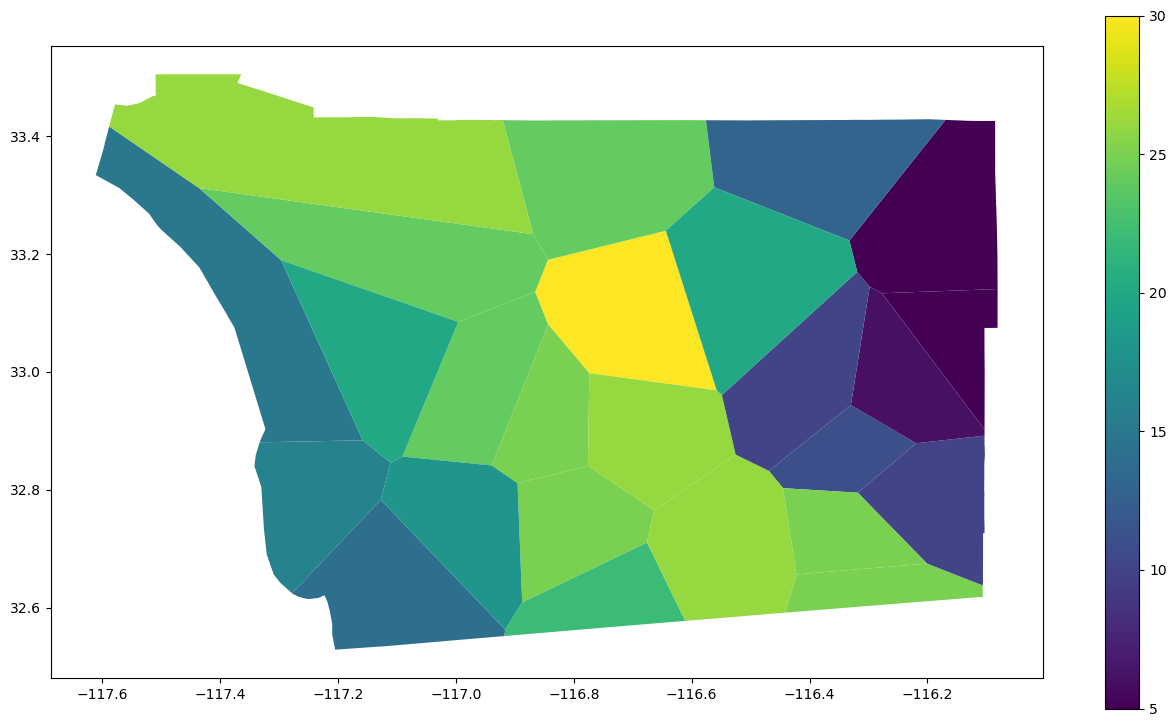

In [15]:
v_gdf.plot(column='inches', legend=True)

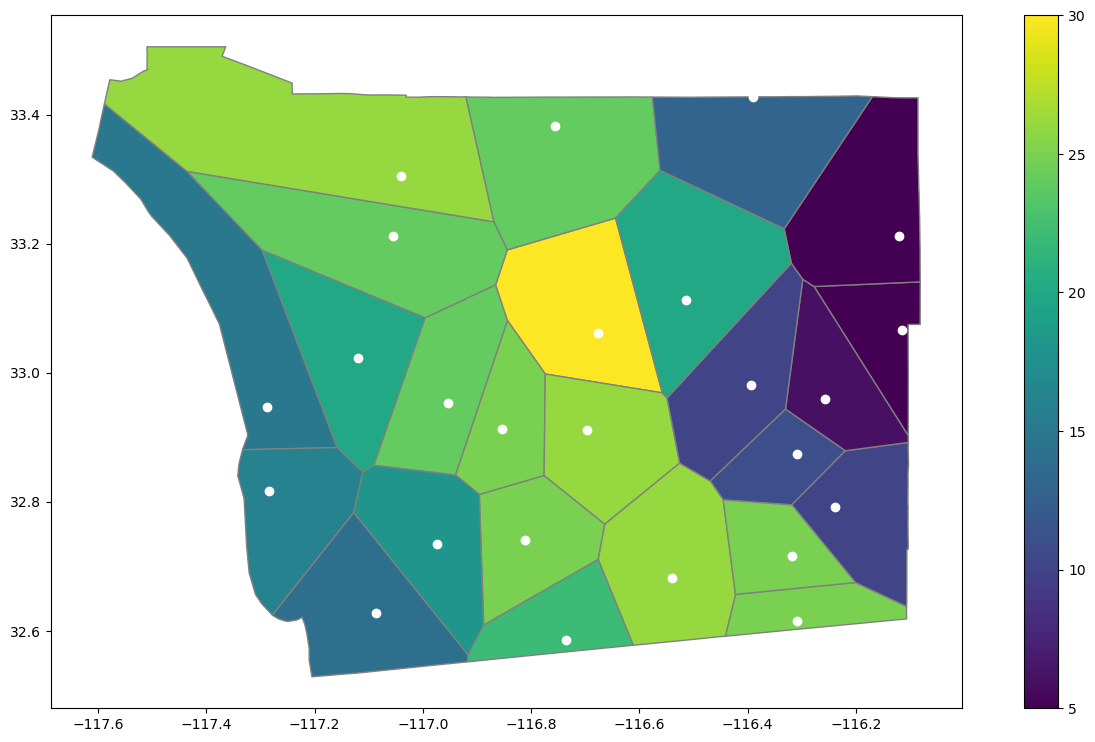

In [16]:
base = v_gdf.plot(column='inches', legend=True,
                 edgecolor='gray')
precip.plot(ax=base, color='w');

### Interpolate to Grids

- hex3 the county
- nearest neighbor interpolators
- 

In [17]:
import tobler

In [18]:
county_utm = county.to_crs(county.estimate_utm_crs())
precip_utm = precip.to_crs(precip.estimate_utm_crs())

In [19]:
from tobler.util import h3fy


In [20]:
county_h3 = h3fy(county_utm)

/home/serge/miniforge3/envs/385f23/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


<Axes: >

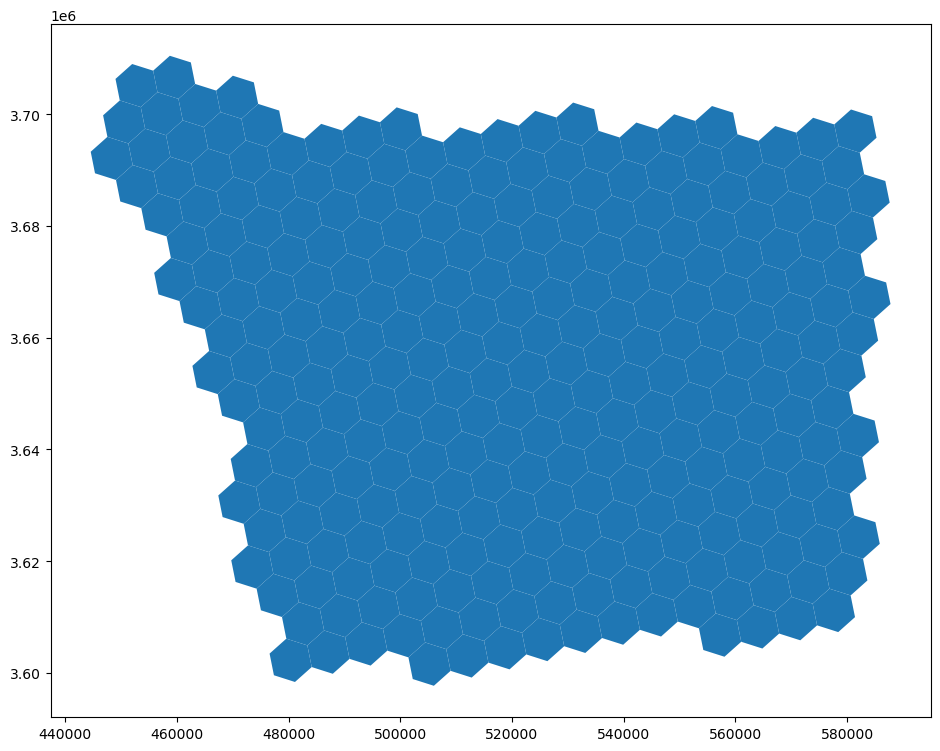

In [21]:
county_h3.plot()

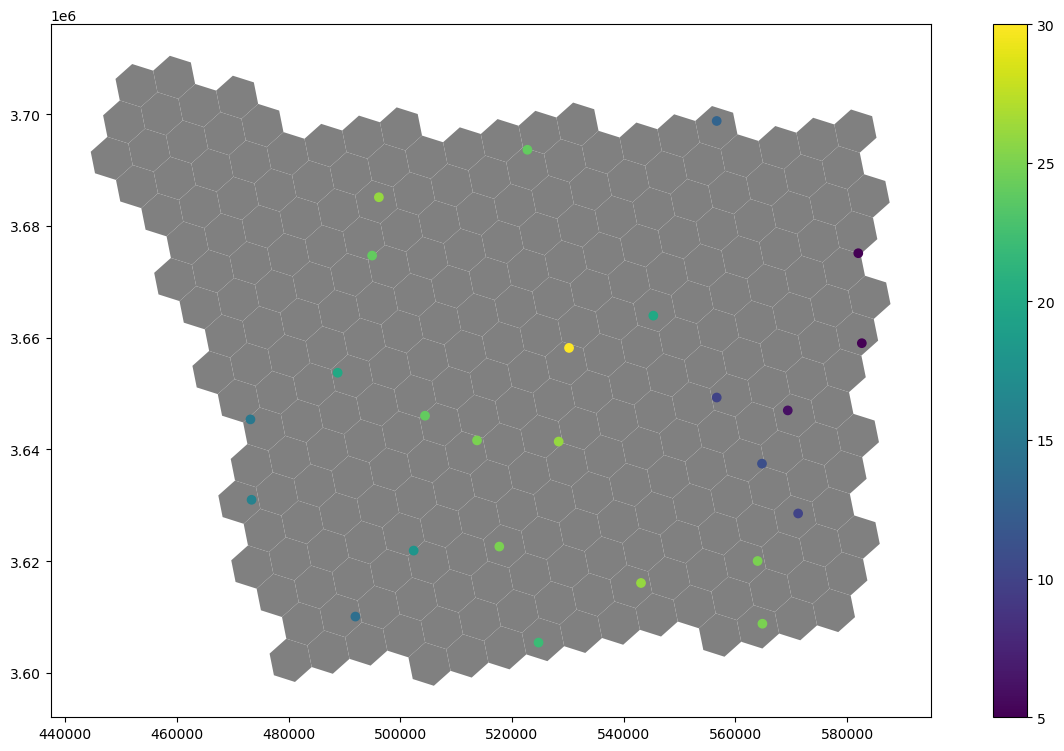

In [22]:
m = county_h3.plot(color='grey')
precip_utm.plot(column='inches', ax=m, legend=True);

### Nearest neighbor

In [23]:
hcents = county_h3.centroid


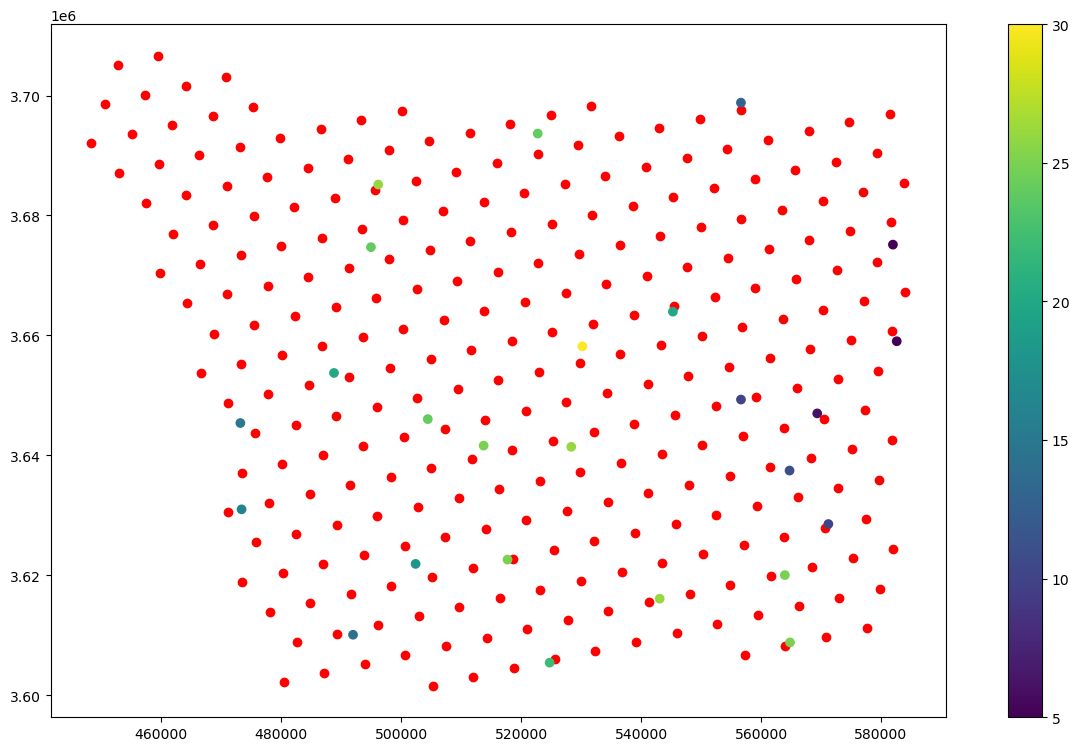

In [24]:
m = hcents.plot(color='r')
precip_utm.plot(column='inches', ax=m, legend=True);

In [25]:
gpd.sjoin_nearest(county_h3, precip_utm, distance_col="distances",
    lsuffix="left", rsuffix="right", exclusive=True)

,geometry,index_right,inches,distances
hex_id,,,,
8629a40cfffffff,"POLYGON ((474069.136 3651385.625, 477061.797 3...",2,15,6062.970244
8629a42a7ffffff,"POLYGON ((460461.590 3666569.984, 463452.235 3...",2,15,24697.772908
8629a40f7ffffff,"POLYGON ((483150.719 3641251.976, 486144.722 3...",2,15,5521.788637
8629a439fffffff,"POLYGON ((464995.449 3661510.686, 467986.766 3...",2,15,18072.743746
8629a42b7ffffff,"POLYGON ((467214.759 3668042.842, 470205.811 3...",2,15,23421.236954
...,...,...,...,...
8629a681fffffff,"POLYGON ((575763.560 3655337.115, 578763.172 3...",0,5,3987.765641
8629a6817ffffff,"POLYGON ((580334.753 3650261.424, 583335.039 3...",0,5,2137.557172
8629a68e7ffffff,"POLYGON ((571194.247 3660410.644, 574193.184 3...",0,5,9356.459172


In [26]:
county_h3.shape

(283, 1)

In [27]:
county_h3['nn1_est'] = gpd.sjoin_nearest(county_h3, precip_utm, distance_col="distances",
    lsuffix="left", rsuffix="right", exclusive=True).inches

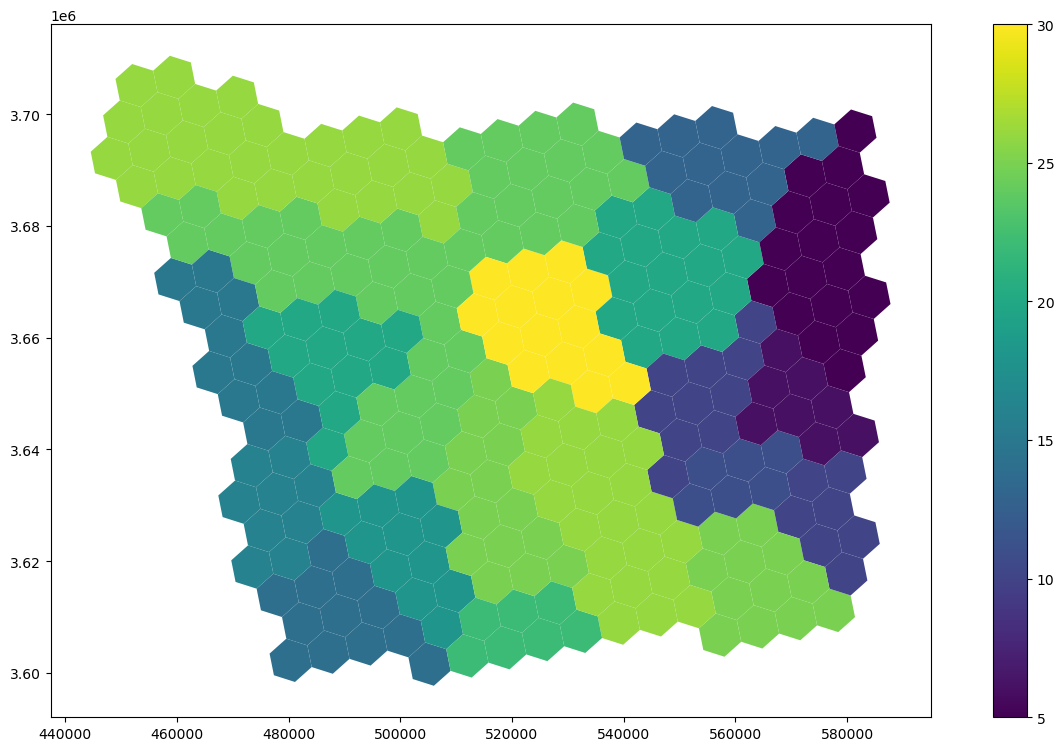

In [28]:
county_h3.plot(column='nn1_est', legend=True);

### Knn5

In [29]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)
print(neigh.predict([[1.5]]))



[0.5]


In [30]:
# Set number of neighbors to use
neighbors = 5

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "uniform") # no distance decay distance

# Fit to observed locations
knn_regressor.fit(precip_utm.get_coordinates(), precip_utm.inches)

KNeighborsRegressor()

In [31]:
knn_regressor.predict(hcents.get_coordinates())


array([19.8, 21.2, 19.4, 24.8, 19.4, 26. , 12.4, 21.8, 20.8, 20.2, 15.8,
       22.4,  9.2, 23.6, 19.4, 23.6, 15.4, 20.8, 21.8, 24.6, 24.8,  9.8,
       23.6, 10.6, 19.4, 23.8, 24.8,  9.2, 20.2, 23.2, 10.6,  9.8, 26.4,
       24.8, 20.4, 24.8, 26. , 10.4, 22. , 22.2, 19.4, 19.4, 18.6, 20.8,
       14.6, 23.8, 24.6, 24.8,  8.4, 22.6, 24.6, 21.8, 18.6, 22.6, 18.4,
       21.8, 21. , 18.6, 19.4, 26. , 21.8, 15.4, 26. , 17.4, 12.4, 20.8,
       15.4, 25. ,  7.4, 21.8, 23.4, 19.4, 23.4, 24.8, 21.8, 25. , 21.8,
       21.8, 21.8,  7.4,  7.8, 26. , 19. , 20.2, 20.2, 24.8, 21.2, 20.2,
       15.4, 22.6, 15.4,  9.8,  7.4, 20.2, 19.8, 15.6, 15.4, 11.4, 21.8,
       19. , 25.6, 18.4,  8.4, 12.4, 15.4, 18.4, 18.6, 20.2, 17.6, 24.8,
       15.4, 21.2, 20.2, 26.4, 10.6, 21.8, 19. , 18.4, 19.4, 24.8, 21.8,
       21.4, 21.6, 21.8, 25. , 24.6, 22.6, 22. , 13.4, 19. , 19.4, 21.8,
       22.4, 23.6, 24.8, 24.8, 20.8, 22.2, 21.8, 25. , 12.4, 20. ,  8.4,
       21. , 19.4,  8.4, 19.4, 19.6, 20.2, 17.6, 23

In [32]:
county_h3['nn5_est'] = knn_regressor.predict(hcents.get_coordinates())


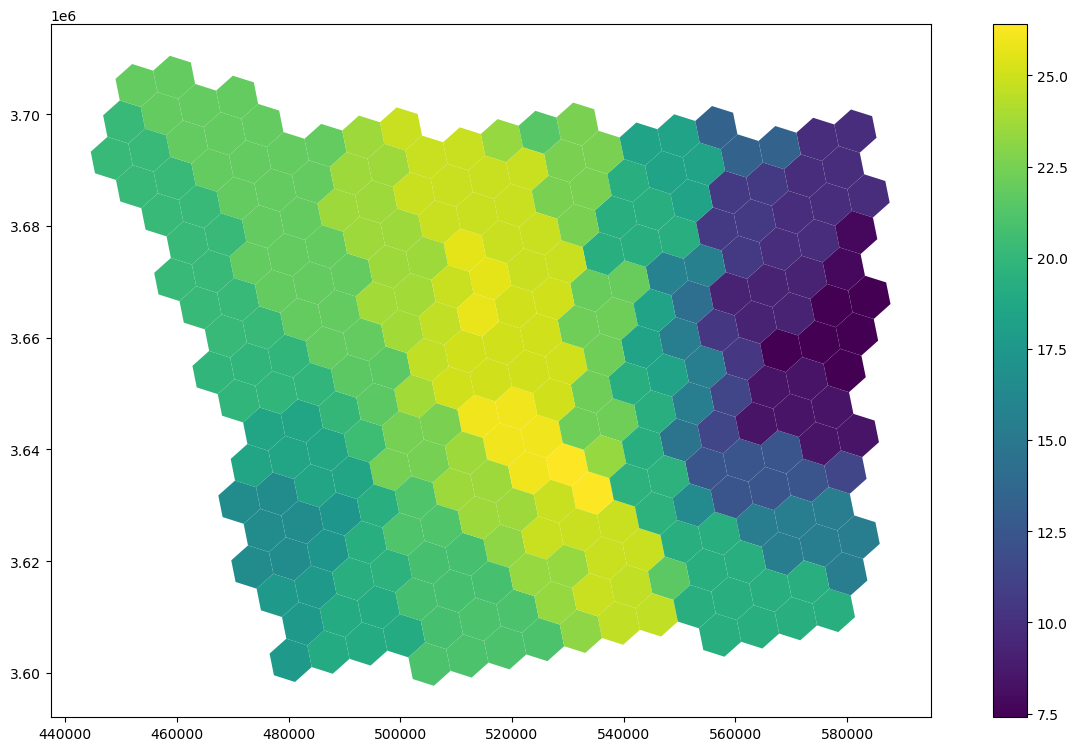

In [33]:
county_h3.plot(column='nn5_est', legend=True);

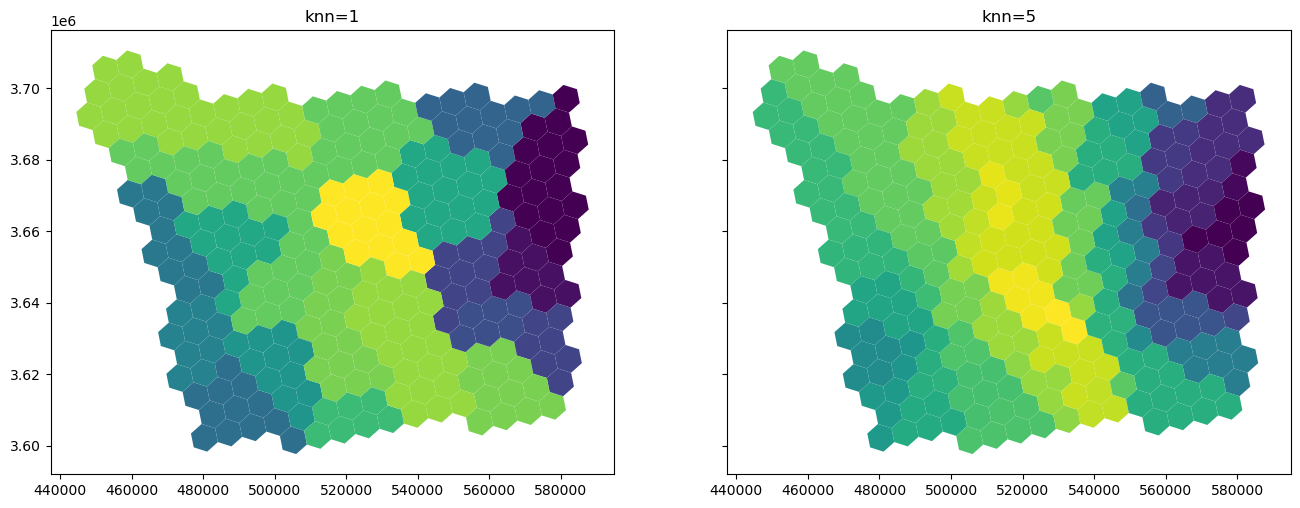

In [34]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
county_h3.plot(column='nn1_est',ax=ax1)
county_h3.plot(column='nn5_est',ax=ax2)
ax1.set_title("knn=1")
ax2.set_title("knn=5");



In [35]:
# Set number of neighbors to use
neighbors = 5

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance") # inverse distance weighting
# Fit to observed locations
knn_regressor.fit(precip_utm.get_coordinates(), precip_utm.inches)

KNeighborsRegressor(weights='distance')

In [36]:
county_h3['nn5id_est'] = knn_regressor.predict(hcents.get_coordinates())


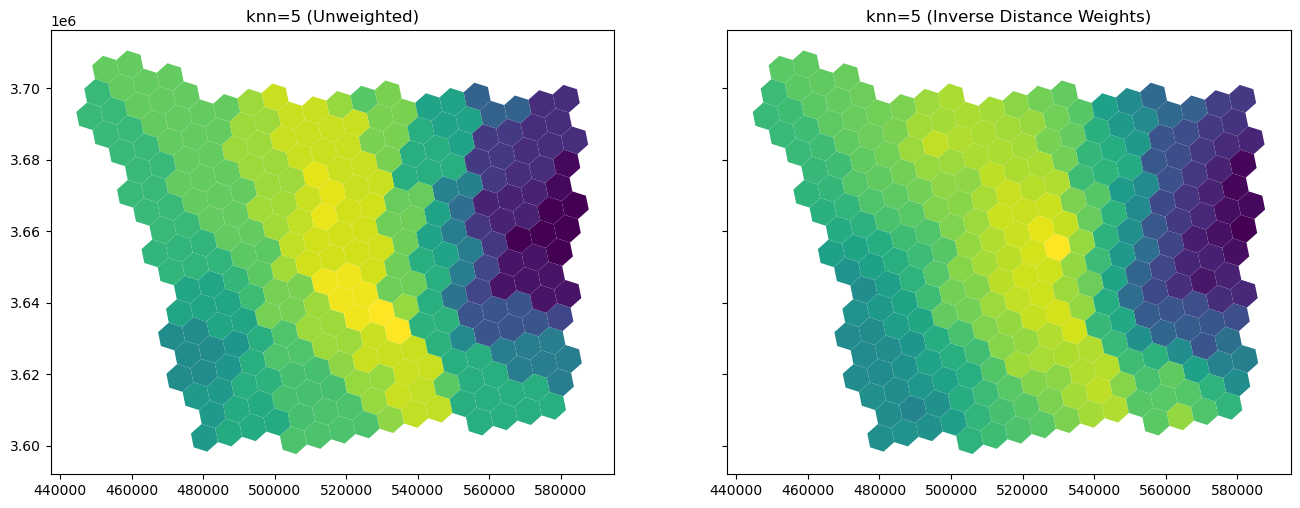

In [37]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
county_h3.plot(column='nn5_est',ax=ax1)
county_h3.plot(column='nn5id_est',ax=ax2)
ax1.set_title("knn=5 (Unweighted)")
ax2.set_title("knn=5 (Inverse Distance Weights)");


## Next

In [38]:
tracts = gdf.dissolve(by='TRACTCE20')

tracts.shape

NameError: name 'gdf' is not defined

### Surface to Area Interpolation

#### Spatial Join on Centroid

In [ ]:
cents = tracts.centroid

In [ ]:
cents.plot()

In [ ]:
type(cents)

In [ ]:
coord_list = [(x, y) for x, y in zip(cents.x, cents.y)]
tracts['centest'] = [x[0] for x in clipped.sample(coord_list)]
tracts.head()

In [ ]:
tracts['centroid'] = tracts.centroid
tracts.set_geometry('centroid', inplace=True)

In [ ]:
tracts.plot(column='centest', legend=True);

In [ ]:
tracts.set_geometry('geometry', inplace=True)
tracts.plot(column='centest', legend=True);

#### Zonal Methods of Surface to Area Interpolation

In [ ]:
import rasterstats

In [ ]:
gdf.head()

In [ ]:
tracts.plot()

In [ ]:
from rasterstats import zonal_stats
tstats = zonal_stats(tracts, "clipped_example.tif",
            stats="count min mean max median")

#elevations2 = zonal_stats(
#    sd_tracts.to_crs(dem.rio.crs),  # Geotable with zones
#    "../data/nasadem/nasadem_sd.tif",  # Path to surface file
#)
#elevations2 = pandas.DataFrame(elevations2)

In [ ]:
tstats[:5]

In [ ]:
tstats = pd.DataFrame(tstats)

In [ ]:
tstats.head()

In [ ]:
tstats.shape

In [ ]:
tracts.shape

In [ ]:
tracts['mean'] = tstats['mean'].values
tracts.plot(column='mean', legend=True);

In [ ]:
tracts['median'] = tstats['median'].values
tracts.plot(column='median', legend=True);

In [ ]:
tracts['range'] = tstats['max'].values - tstats['min'].values
tracts.plot(column='range', legend=True);

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import seaborn as sns

In [ ]:
sns.scatterplot(data=tracts, x='centest', y='mean')
plt.plot([10, 40], [10, 40]);

In [ ]:
sns.scatterplot(data=tracts, x='median', y='mean')
plt.plot([10, 40], [10, 40]);